In [1]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [2]:

notebook = isnotebook()   ########## OVERRIDE HERE IF NOT WORKING !!!


if notebook:
    
    # Compile script/modules from notebooks
#     !jupyter nbconvert --to script union_find.ipynb
    
    !jupyter nbconvert --to script dtw.ipynb
    
#     from sys import stdin
#     testFile = open("test_case.txt")
#     def testInput():
#         return testFile.readline().strip()
#     old_stdin, stdin = stdin, testFile
#     old_input, input = input, testInput
    
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    %matplotlib inline

[NbConvertApp] Converting notebook dtw.ipynb to script
[NbConvertApp] Writing 8165 bytes to dtw.py


In [3]:
import sys
import numpy as np
from time import time


## Algorithms

In [4]:
# Core Functions
def dist1d(a, b):
    return (a-b)**2

def dist3d(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2

def dtw(q, c, w=1, tresh=None, log=0):
    if len(c)<len(q):
        q, c = c, q
    
    # M Global  M = [max(len(q))*2][2]
    #Talvez compense trocar as dimensões de M pra ver ser acelera
    
    w= round((len(q)-1)*w) # band width between [0, len(q)-1] inclusivo
    m = (len(q)-1)/(len(c)-1) # line slope
    
    norm = dist3d if type(q[0]) == list else dist1d
    
    if log: L = [[float(log)]*(len(c)+1) for i in range(len(q)+2)]
    
    for i,_ in enumerate(q):
        M[i][-1%2]=float('inf')
        if log: L[i][-1] = float('inf')
    
    M[-1][-1%2] = 0 # caso base
    if log: L[-1][-1] =0
        
    for j in range(len(c)):
        y=round(m*j) # center of band
        M[max(-1,y-w-1)][j%2] = M[min(y+w+1,len(q))][j%2] = float('inf')
        if log: L[max(-1,y-w-1)][j] = L[min(y+w+1,len(q))][j] = float('inf')
        
        dist = float('inf')
        for i in range(max(0,y-w), min(y+w+1,len(q))):
#             M[i][j%2] = np.linalg.norm(q[i]-c[j]) \ # numpy arrays were elegant for varible dimensions but too slow for many operations
            M[i][j%2] = norm(q[i],c[j]) \
            + min(M[i][(j-1)%2], M[i-1][(j-1)%2], M[i-1][j%2])
            if log: L[i][j]=M[i][j%2]
            dist = min(dist, M[i][j%2])
        if tresh and dist >= tresh:
            return(float('inf'))
        
    if log: return L, dist
    return(dist)

def nn(q, train, w, prune=True):
    dist = float('inf')
    closer = None
    for i, c in enumerate(train):
        aux = dtw(q, c, w, dist if prune else None)
        if aux < dist:
            dist, closer = aux, i
    return closer
            

## CLI behaviour

In [6]:
if not notebook:
    

    if len(sys.argv) < 3:
        print (
        "usage: python3 dtw.py [--3d] test_file train_file [Satoe_window] \n\
        Will use the first ellement in test_file as query ellement,\n\
        and return the nearest neighbor in train\
        Satoe_indow is 0 to 1 inclusive"
        )
        
        input()
        exit()
        
    w=1
    d3 = false
    if argv[2]=='--3d':
        test = open(argv[3])
        train = open(argv[4])
        d3 = true
    else:
        test = open(argv[2])
        train = open(argv[3])
    
    
    if not d3:
        test = [f.split() for f in test]
        test_class = [int(i[0]) for i in test]
        test_data = [list(map(float, l[1:])) for l in test]
        
        train = [f.split() for f in train]
        train_class = [int(i[0]) for i in train]
        train_data = [list(map(float, l[1:])) for l in train]
    else:
        test3d = [f.split() for f in test]
        test_class = [int(i[0]) for i in test3d]
        test_data= [[ list(map(float,p)) for p in zip(*[iter(l[1:])]*3)] for l in test3d]
        
        train3d = [f.split() for f in train]
        train_class = [int(i[0]) for i in train3d]
        train_data= [ [list(map(float,p)) for p in zip(*[iter(l[1:])]*3)] for l in train3d]
        
    
        closest = nn(test_data[0],train_data)

        
        
    exit()

## Plot Function

In [7]:
# Plot function

# colormap
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.0,  0.1, 0.8),
                   (1e-5,  0.0, 0.0),
                   (0.4,  1.0, 1.0),
                   (1.0,  1.0, 1.0),
                  ),

         'green': ((0.0,  0.1, 0.8),
                   (1e-5,  1.0, 1.0),
                   (0.6,  1.0, 1.0),
                   (1.0,  0.1, 0.1),
                  ),

         'blue':  ((0.0,  0.1, 0.8),
                   (1e-5,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}
cmap = LinearSegmentedColormap('ggr', cdict)


def plot(L, start=0, cm=cmap, colorbar = False):


    L = np.roll(L,-start,(0,1))

    plt.figure(figsize=(15,15))
    plt.imshow(np.array((L))[::-1],cmap=cm)
    ax = plt.gca()
    ax.set_xticks(np.arange(.5, len(L[0])-1, 1))
    ax.set_yticks(np.arange(.5, len(L)-1, 1))
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.set_xticks(np.arange(len(L[0])), minor=True )
    ax.set_yticks(np.arange(len(L)), minor=True)
    ax.set_xticklabels(np.arange(len(L[0]))+start, minor=True)
    ax.set_yticklabels((np.arange(len(L))+start)[::-1], minor= True)

    ax.tick_params(which='minor', labeltop=True, labelright=True)


    ax.grid(color='gray', linestyle='-', linewidth=2)
    if colorbar: plt.colorbar()
    plt.show()
    plt.close() 


# L, d = dtw(test3d_data[366],train3d_data[0], w=.5,log=-5)
# print(d)
# plot(L)

# Loading test files

In [8]:
test = [f.split() for f in open('teste.txt')]
test_class = [int(i[0]) for i in test]
test_data = [list(map(float, l[1:])) for l in test]

In [9]:
train = [f.split() for f in open('treino.txt')]
train_class = [int(i[0]) for i in train]
train_data = [list(map(float, l[1:])) for l in train]

In [10]:
test3d = [f.split() for f in open('teste3D.txt')]
test3d_class = [int(i[0]) for i in test3d]
test3d_data= [[ list(map(float,p)) for p in zip(*[iter(l[1:])]*3)] for l in test3d]

In [11]:
train3d = [f.split() for f in open('treino3D.txt')]
train3d_class = [int(i[0]) for i in train3d]
train3d_data= [ [list(map(float,p)) for p in zip(*[iter(l[1:])]*3)] for l in train3d]

In [12]:
height = np.max([len(l) for l in test_data+train_data+test3d_data+train3d_data])
M = [[float('inf')]*2 for i in range(height+2)]

## Example

Example of dtw computation. the log flag instantiates a log matrix. Without it only 2 colums are instantiated. The value of the flag is the value of the empty cells used to customize the color.

91.36978922016687


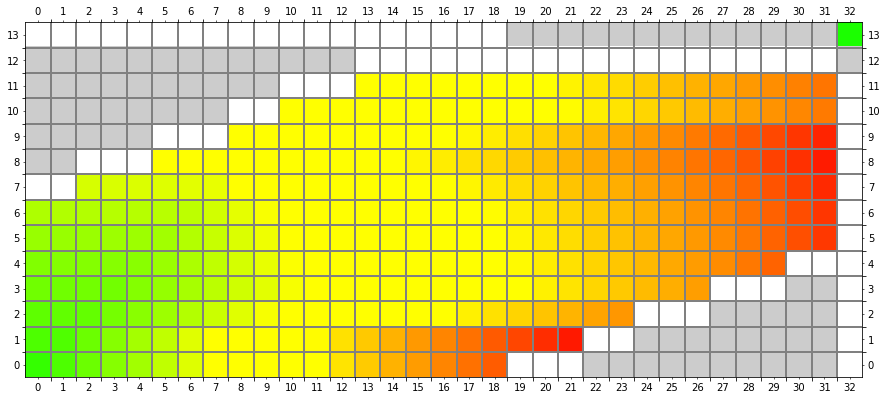

In [13]:
L, d = dtw(test3d_data[366],train3d_data[0], w=.5,log=-5)
print(d)
plot(L)

## Benchmarks

In [ ]:
# Benchmark 1D
M = [[float('inf')]*3 for i in range((200*2))]
results=[["w", "precision", "time"]]
start=time()
last = start
for w in [0,.01,.05,.1,.2,.5,1]:
    hits=0
    for i, q in enumerate(test_data):
        nearest = nn(q, train_data, w)
        if test_class[i] == train_class[nearest]:
            hits+=1
    prec = hits/len(test_data)
    current = time()
    results.append([w,prec,current-last])
    print('w:',w,', precision:', prec,'time:', current-last)
    last=current
    
np.save('results1d-list', results)


In [ ]:
# Benchmark 3D

M = [[float('inf')]*3 for i in range((200*2))]
results=[["w", "precision", "time"]]
start=time()
last = start
for w in [0,.01,.05,.1,.2,.5,1]:
    hits=0
    for i, q in enumerate(test3d_data):
        nearest = nn(q, train3d_data, w )
        if test3d_class[i] == train3d_class[nearest]:
            hits+=1
    prec = hits/len(test3d_data)
    current = time()
    results.append([w,prec,current-last])
    print('w:',w,', precision:', prec,'time:', current-last)
    last=current
    
np.save('results3d-list', results)
